## Imports

In [1]:
import sys
import nltk
import numpy as np
import pandas as pd
import pickle
# from helpers import *
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
import os
from matplotlib import pyplot as plt
sys.path.append(".")
sys.path.append("..")
# Use the Azure Machine Learning data preparation package
# from azureml.dataprep import package

## Set params

In [2]:
column_to_predict = "urgency"
# Supported datasets:
# ticket_type
# business_service
# category
# impact
# urgency
# sub_category1
# sub_category2

classifier = "SVM"  # Supported algorithms # "SVM" # "NB"
use_grid_search = True  # grid search is used to find hyperparameters. Searching for hyperparameters is time consuming
remove_stop_words = True  # removes stop words from processed text
stop_words_lang = 'english'  # used with 'remove_stop_words' and defines language of stop words collection
use_stemming = False  # word stemming using nltk
fit_prior = True  # if use_stemming == True then it should be set to False ?? double check
min_data_per_class = 1  # used to determine number of samples required for each class.Classes with less than that will be excluded from the dataset. default value is 1

if classifier == "KNN":
    use_grid_search = False

## Load dataset

In [3]:
# loading dataset from dprep in Workbench    
# dfTickets = package.run('AllTickets.dprep', dataflow_idx=0) 

# loading dataset from csv
dfTickets = pd.read_csv(
    './datasets/all_tickets.csv',
    dtype=str
)  

## Select 'TEXT' column and remove poorly represented classes

In [4]:
text_columns = "body"  # "title" - text columns used for TF-IDF

# Removing rows related to classes represented by low amount of data
print("Shape of dataset before removing classes with less then " + str(min_data_per_class) + " rows: "+str(dfTickets.shape))
print("Number of classes before removing classes with less then " + str(min_data_per_class) + " rows: "+str(len(np.unique(dfTickets[column_to_predict]))))
bytag = dfTickets.groupby(column_to_predict).aggregate(np.count_nonzero)
tags = bytag[bytag.body > min_data_per_class].index
dfTickets = dfTickets[dfTickets[column_to_predict].isin(tags)]
print(
    "Shape of dataset after removing classes with less then "
    + str(min_data_per_class) + " rows: "
    + str(dfTickets.shape)
)
print(
    "Number of classes after removing classes with less then "
    + str(min_data_per_class) + " rows: "
    + str(len(np.unique(dfTickets[column_to_predict])))
)

Shape of dataset before removing classes with less then 1 rows: (43107, 7)
Number of classes before removing classes with less then 1 rows: 3
Shape of dataset after removing classes with less then 1 rows: (43107, 7)
Number of classes after removing classes with less then 1 rows: 3


## Prepare data and labels and split them to train and test sets

In [5]:
labelData = dfTickets[column_to_predict]
data = dfTickets[text_columns]

# Split dataset into training and testing data
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labelData, test_size=0.2
)  # split data to train/test sets with 80:20 ratio

## Extracting features from text

In [6]:
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        stemmer = SnowballStemmer("english", ignore_stopwords=True)
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

In [7]:
# Count vectorizer
if remove_stop_words:
    count_vect = CountVectorizer(stop_words=stop_words_lang)
elif use_stemming:
    count_vect = StemmedCountVectorizer(stop_words=stop_words_lang)
else:
    count_vect = CountVectorizer()

vectorized_data = count_vect.fit_transform(train_data)
vectorized_data.shape

(34485, 10741)

In [8]:
tfidf = TfidfTransformer()
features = tfidf.fit_transform(vectorized_data)
features.shape

(34485, 10741)

## Using pipeline to preprocess data and train classifier

In [9]:
# Fitting the training data into a data processing pipeline and eventually into the model itself
if classifier == "NB":
    print("Training NB classifier")
    # Building a pipeline: We can write less code and do all of the above, by building a pipeline as follows:
    # The names ‘vect’ , ‘tfidf’ and ‘clf’ are arbitrary but will be used later.
    # We will be using the 'text_clf' going forward.

    text_clf = Pipeline([
        ('vect', count_vect),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB(fit_prior=fit_prior))
    ])
    text_clf = text_clf.fit(train_data, train_labels)
elif classifier == "D3":
    print("Training D3 classifier")
    # Building a pipeline: We can write less code and do all of the above, by building a pipeline as follows:
    # The names ‘vect’ , ‘tfidf’ and ‘clf’ are arbitrary but will be used later.
    # We will be using the 'text_clf' going forward.

    text_clf = Pipeline([
        ('vect', count_vect),
        ('tfidf', TfidfTransformer()),
        ('clf', DecisionTreeClassifier())
    ])
    text_clf = text_clf.fit(train_data, train_labels)
elif classifier == "SVM":
    print("Training SVM classifier")
    # Building a pipeline: We can write less code and do all of the above, by building a pipeline as follows:
    # The names ‘vect’ , ‘tfidf’ and ‘clf’ are arbitrary but will be used later.
    # We will be using the 'text_clf' going forward.

    text_clf = Pipeline([
        ('vect', count_vect),
        ('tfidf', TfidfTransformer()),
        ('clf', SVC(kernel='linear'))
    ])
    text_clf = text_clf.fit(train_data, train_labels)
elif classifier == "KNN":
    print("Training KNN classifier")
    # Building a pipeline: We can write less code and do all of the above, by building a pipeline as follows:
    # The names ‘vect’ , ‘tfidf’ and ‘clf’ are arbitrary but will be used later.
    # We will be using the 'text_clf' going forward.

    text_clf = Pipeline([
        ('vect', count_vect),
        ('tfidf', TfidfTransformer()),
        ('clf', KNeighborsClassifier(n_neighbors = 3))
    ])
    text_clf = text_clf.fit(train_data, train_labels)

Training SVM classifier


## Use GridSearchCV to search for best set of parameters

In [10]:
if use_grid_search:
    # Grid Search
    # Here, we are creating a list of parameters for which we would like to do performance tuning.
    # All the parameters name start with the classifier name (remember the arbitrary name we gave).
    # E.g. vect__ngram_range; here we are telling to use unigram and bigrams and choose the one which is optimal.

    # NB parameters
    parameters = {
        'vect__ngram_range': [(1, 1), (1, 2)],
        'tfidf__use_idf': (True, False)
    }

    # Next, we create an instance of the grid search by passing the classifier, parameters
    # and n_jobs=-1 which tells to use multiple cores from user machine.
    

    gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
    
    
    gs_clf = gs_clf.fit(train_data, train_labels)

    # To see the best mean score and the params, run the following code
    gs_clf.best_score_
    gs_clf.best_params_

gs_clf.best_params_

## Evaluate the model

In [11]:
print("Evaluating model")
# Score and evaluate model on test data using model without hyperparameter tuning
predicted = text_clf.predict(test_data)
prediction_acc = np.mean(predicted == test_labels)
print("Confusion matrix without GridSearch:")
print(metrics.confusion_matrix(test_labels, predicted))
print("Mean without GridSearch: " + str(prediction_acc))

# Score and evaluate model on test data using model WITH hyperparameter tuning
if use_grid_search:
    predicted = gs_clf.predict(test_data)
    prediction_acc = np.mean(predicted == test_labels)
    print("Confusion matrix with GridSearch:")
    print(metrics.confusion_matrix(test_labels, predicted))
    print("Mean with GridSearch: " + str(prediction_acc))

Evaluating model
Confusion matrix without GridSearch:
[[ 820  303   39]
 [ 390  518   70]
 [   1    1 6480]]
Mean without GridSearch: 0.9067501739735561
Confusion matrix with GridSearch:
[[ 833  281   48]
 [ 394  514   70]
 [   3    2 6477]]
Mean with GridSearch: 0.907446068197634


## Test data with inputs

### Read Data

In [12]:
dfTestTickets = pd.read_csv(
    './test data/testing_tickets.csv',
    dtype=str
)
test_input_data = dfTestTickets[text_columns]

### Without GridSearchCV

In [13]:
prediction_input = text_clf.predict(test_input_data)

i = 0
for result in predicted:
    
    print(text_columns,",")
    print(test_data.iloc[i])
    print("--"*30)
    print(column_to_predict,":", result)
    print("==="*30)
    i+=1

body ,
july rom extension dear extend rom memory disk drive which cause problems please help thanks
------------------------------------------------------------
urgency : 3
body ,
friday re action required apply updates run updates morning please date updates thanks friday action required apply updates hello constantly monitoring updates status vulnerable infections march updates were yet installed require perform subsequent by failing apply these updates lead infections which manifest files by encrypting which turn lead commercial consequences please find instructions installing updates note updates while devices offices well by having turned especially useful take devices recommend perform these noon going lunch disrupt activities make connected guest preferably by cable device connected by perform restart make device added proper order updates become available updates by pressing key combination display search type update button choose install updates restart device afterwards repea

body ,
members agile hello dear please add members agile kind regards discipline lead
------------------------------------------------------------
urgency : 3
body ,
wednesday pm required functions importance high hi please help view delete functions reports layouts community highlighted red upload change information level today thank
------------------------------------------------------------
urgency : 3
body ,
wednesday pm hello please setup assign also please add members thanks senior developer
------------------------------------------------------------
urgency : 3
body ,
sent monday march low score incident logged with caller information hello we have received low satisfaction notification yesterday th march afternoon you can attached upon checking for low score ticket was able find by checking caller ticket history nor by checking for complaint tickets or by conducting searches for ticket summary we have run report for complaint tickets logged for month we found ticket raised ye

body ,
wednesday pm hi colleague has low speed her computer considering high volume processed these days please help give back days manage help today highly appreciated thank
------------------------------------------------------------
urgency : 3
body ,
re upgrade process how free dear finished upgrading help thanks galaxy date upgrade process how free hello found out announcements rollout upgrade started ago receiving because drive enough perform upgrade process minimum requirement free advised follow next steps free drive move personal separate personal drive regarding work files please move onto storage available app located storage tools size folders files helpful tool easily identify biggest files folders available after file move please note member teams please apply upgrade yet kind regards ext
------------------------------------------------------------
urgency : 3
body ,
tuesday november re please action told via enter st july which contradicts were given started logging said

body ,
create accounts hi please provision accounts assignment done side thank test consultant mobile
------------------------------------------------------------
urgency : 3
body ,
sent monday sheet can you remove him sheet developer senior technician belgrade belgrade senior technician active direct thanks
------------------------------------------------------------
urgency : 2
body ,
sent tuesday view issue hello can you please raise ticket for there was issue with veronicas view configuration kind regards application developer
------------------------------------------------------------
urgency : 1
body ,
purchase po dear purchased digital mb please log allocation after receive item please take consideration mandatory receipts section order receive item ordered how video link kind regards administrator
------------------------------------------------------------
urgency : 3
body ,
october pm hi sd please rise order regards engineer
--------------------------------------------------

------------------------------------------------------------
urgency : 1
body ,
sent friday october overdue expense report ca la mine expense report el pending manager approval expense report forward la sa ca la client si si ca sa approvers error occurred while displaying history table error evaluating routing slip check underlying exception correct error routing slip expense report sent october re overdue expense report ca intra si sa fie parte history print expense report si sa approval flow ca sa fie multi approval flow si records expense reports care la mine si la mine history la cine approval se se sa fie si si va sa la sent thursday october re overdue expense report ca se la pending manager approval la pus sa expense report si ca intra si la tine sent thursday october re overdue expense report task list mew expense report la cine expense tau si sa follow up sent thursday october overdue expense report sent thursday october overdue expense report hello everyone care va ca expense 

urgency : 1
body ,
upgrade failed hello please raise ticket for issue below upgrade error thank you kind regards infrastructure manager ext phone sent friday upgrade failed hello sorry bother you can anyone help with upgrade regard developer en sent wednesday upgrade failed hello updating operating machine failed please find attached file upgrade failed regards developer en
------------------------------------------------------------
urgency : 1
body ,
amp installation hello please informed virus solution has changed amp client automatic installation available devices therefore please kind share availability install software machine possible please log effort assign queue thank understanding engineer ext
------------------------------------------------------------
urgency : 3
body ,
thursday library requesting library links library manage setting library hello order find out compiling knowledge base analysis discipline directed site thank note site site site provides central storage co

urgency : 3
body ,
wednesday july pm reassignment hi please reassign currently he assigned therefore receive his annual leave requests thank
------------------------------------------------------------
urgency : 3
body ,
hello please assist by checking leaver template logging tickets undefined summary instead leaver name even name input initial form please let require additional details thank
------------------------------------------------------------
urgency : 3
body ,
sign issues dears assign please regards engineer sign issues importance high good noon dear colleagues since yesterday sign help possible create urgent thank specialist
------------------------------------------------------------
urgency : 3
body ,
client moved hi please move processing both currently created codes automation streams known pipeline regards fin floor blvd district
------------------------------------------------------------
urgency : 3
body ,
monitor monitor la
------------------------------------------

body ,
december pm pm hi please puma these thank
------------------------------------------------------------
urgency : 3
body ,
sent tuesday july hardware request th floor printer hi would need your check th floor printer currently does respond believe there might be some old documents queue blocking flow thanks manager
------------------------------------------------------------
urgency : 1
body ,
sent monday access manager error importance high hi get error when please help with warm regards head analysis
------------------------------------------------------------
urgency : 1
body ,
july folder hello awesome document guest passwords fix pretty please she given ago please out she needs document she thanks wonderful
------------------------------------------------------------
urgency : 3
body ,
friday february pm re setup attached thank february re setup hello please fill attached template setup old version after filled proceed logging tickets kind regards analyst ext hub friday febr

------------------------------------------------------------
urgency : 1
body ,
tuesday pm re sonar hi please pass sonar over pm best given pm design lead kind think he has regards
------------------------------------------------------------
urgency : 3
body ,
sent monday card error hello have issue when trying log status card error when try delete leave wed able could you please help with issue mentioned senior software tester
------------------------------------------------------------
urgency : 1
body ,
friday hello raised pending status since please let approve thank senior application engineer
------------------------------------------------------------
urgency : 3
body ,
purchase po dear purchased requested by adapter adapter adapter please log allocation after receive item please take consideration mandatory receipts section order receive item ordered how video link kind regards administrator
------------------------------------------------------------
urgency : 3
body ,
re star

body ,
sent thursday november feedback issue hello could you please be kind have look below raise issue under name please let know if can assist best regards customer care en sent thursday november feedback issue dear ticket cooling pad request resolved received today about giving feedback for but was able give opinion due error occurred shown attached would like ask you for advice thank you best regards software developer
------------------------------------------------------------
urgency : 2
body ,
thursday pm left dear left changed changed discipline well he believe has more details changes done testing discipline taking consideration changed cannot approve days off annual leaves anymore needs regulated too please approver bench until become billable approve days off annual leaves thank regards test lead
------------------------------------------------------------
urgency : 3
body ,
tuesday july pm re card hi please enable card card belonged he returned thank tuesday july pm card v

body ,
july leaver form leave date location center hello leaver form has filled by name leaving date location center ad forwarder leaver mailbox did leaver roaming profile did leaver ad rights personal mailbox approver did leaver rights inventory storage required information name work location details floor floor seat did leaver did leaver token did leaver mobile phone subscription did leaver other commercial accounts leaver has detected changed automatic by approver backup pm purchase coordinator approver approver approver approver discipline responsible other did leaver did leaver did leaver did leaver did leaver number did leaver extension leaving details unplanned comments needed tickets automatically logged best regards note mailbox receive messages
------------------------------------------------------------
urgency : 3
body ,
wednesday march pm re over hi thank much maybe worth guys out overkill today thank few other issues going today things users sessions re over course these 

body ,
hello please move users groups permissions myself looking forward hearing thanks kind regards
------------------------------------------------------------
urgency : 3
body ,
friday pm la pot
------------------------------------------------------------
urgency : 3
body ,
hello we want inform you web app access working you can use documents collaborate with your colleagues web app working fine with ie if you need more assistance feel free contact engineer en sent monday october access hi have tried access while client site with open client without can you explain how access please error code forbidden server denied specified uniform resource locator contact server administrator manager
------------------------------------------------------------
urgency : 1
body ,
failed upgrade dear could you please help solving issue faced upgrading raised below regards sent tuesday failed upgrade hi tried update got below error could you please advise what actions should order upgrade properly 

body ,
wednesday march pm re downloading files hi writing right please help question thanks thursday march pm re downloading files hi reminder friday march downloading files hi help after technical interview each technical evaluator fills technical report possible download document find thanks
------------------------------------------------------------
urgency : 3
body ,
board hi we have some problems accessing board for users with role developers can access board consequently have access any story please advise thank you senior developer address blvd th floor district
------------------------------------------------------------
urgency : 2
body ,
re folders hi wanted say working archive persistent thanks much programme portfolio officer mobile phone
------------------------------------------------------------
urgency : 3
body ,
purchase po dear purchased tv clip mount stand holder motion please log allocation after receive item please take consideration mandatory receipts section ord

body ,
purchase po hi purchased description control si la backbone si video si video please log allocation please take consideration mandatory receipts section order receive item ordered how video please explorer kind regards administrator
------------------------------------------------------------
urgency : 3
body ,
usage hi working review processes looking usage existing provide usage per towards provide usage thank much senior
------------------------------------------------------------
urgency : 3
body ,
urgent access problems since password change dear unfortunately experiencing access problems especially but also occasionally yammer etc since changed password yesterday there way overcome constant ask for providing password yes provided correct one thanks for your holds significantly back working kind regards head frankfurt main frankfurt main
------------------------------------------------------------
urgency : 1
body ,
additional cable dear additional cable please provide than

------------------------------------------------------------
urgency : 3
body ,
upgrade fail hi tried upgrade for win but failed attached images can you please advice thank you testing
------------------------------------------------------------
urgency : 1
body ,
tuesday pm re xxx thanks please add mars pl br kind regards re xxx thing tuesday re xxx thanks please looks slightly less sophisticated fake received example helpful routing kind regards xxx hello attack ads earlier seems got linked somehow clients these bigger companies bait best head agile tuesday xxx tag die bel auf bitte auf ho bach den bitte
------------------------------------------------------------
urgency : 3
body ,
thursday july tasks details hi tasks details phases required activities control etc po tuesday july pm hello everyone pleased announce today launching today submit reclaim purchase requisitions please carefully contains information regarding how completing raising requisitions where help log log please en

urgency : 3
body ,
sent tuesday march phone available hello phone times square meeting room available could you please fix thank you applications engineer ext
------------------------------------------------------------
urgency : 1
body ,
thursday pm allocation required hello please allocate macs he assigned require possible kind regards head ext
------------------------------------------------------------
urgency : 3
body ,
sent tuesday contacts chart opportunity forecasting view applications discipline lead sent tuesday re contacts chart opportunity forecasting view hello please specify what projects moment we can ask our colleagues sync them with if you have some available let call discuss about how you can get data for records could we add back contact form applications discipline lead sent tuesday re contacts chart opportunity forecasting view thanks figured out how export contacts one but still can fields did export shows selected for right fields populated then did separate expo

body ,
friday october pm hello va ne date administration officer
------------------------------------------------------------
urgency : 3
body ,
tuesday pm purchase po dear purchased fibber module nm please log allocation kind regards administrator
------------------------------------------------------------
urgency : 3
body ,
sent thursday march issues hi for code client get error total being calculated costs showing although there days forecasted per picture attached please pictures attached with screens mentioned above could you please help with thank you officer
------------------------------------------------------------
urgency : 1
body ,
thursday re starter form date thursday starter form date hello please fill he going july thanks ext ale street center
------------------------------------------------------------
urgency : 3
body ,
guys with if you get these hi please advise how received attached every week anything can thanks sent wednesday december re guys with if you get thes

------------------------------------------------------------
urgency : 3
body ,
pm role hi moved roles today please change her role also please assign role reports let thank
------------------------------------------------------------
urgency : 3
body ,
tuesday december pm social hello addresses social colleagues thank find out more about experience blvd floor district
------------------------------------------------------------
urgency : 3
body ,
ownership hi since tomorrow remind revoke ownership over accounts events assign person choosing thanks
------------------------------------------------------------
urgency : 3
body ,
backups needed production environment hi please log database backup core session jobs databases please backups via because update environment thanks best regards application engineer
------------------------------------------------------------
urgency : 3
body ,
comers dear joined please resources per attached also create confluence thank
------------------------

------------------------------------------------------------
urgency : 3
body ,
can due wrong password using domain password
------------------------------------------------------------
urgency : 1
body ,
july pm booking details visible meeting rooms importance high hi please make meeting rooms calendar visible currently has booked thank blvd rd floor
------------------------------------------------------------
urgency : 3
body ,
problem with importing hi have noticed have different options for populating report for days week for dates should populate assignment number payroll type records presented following picture other hand for dates getting window for populating report presented following picture if mistaken was case begging week can you please check engineer
------------------------------------------------------------
urgency : 1
body ,
wednesday pm confluence testing dear please help creation confluence testing thanks head testing colombia
---------------------------------------

urgency : 1
body ,
thursday december report issue days dear please advise issue client report uploaded link reports layouts reports forms although updated by refresh button days forecast analysis although entire attached report evidence help thank officer
------------------------------------------------------------
urgency : 3
body ,
tuesday february pm re code setup hi bid margin since pre code attaching updated form regards february re code setup hello please also fill bid margin form then return needed order correctly process create best regards analyst ext hub tuesday february pm code setup hello please setup code per attached form thanks
------------------------------------------------------------
urgency : 3
body ,
friday july pm updates hello please find attached excel file changes leavers please help respect logging tracking purposes let needed thank kind regards
------------------------------------------------------------
urgency : 3
body ,
pm re updated links hi happens thank

needed hi please help creation asap attached thank
------------------------------------------------------------
urgency : 3
body ,
error updating file projects hello please help with solution related invoicing process when trying update file keep receiving error details attached thank you manager sent friday recognition invoicing month end good afternoon please find closing schedule below cob th accounts payable close process supplier cob th close registering non cost accruals prepayments mid th provisional release for projects with labour fixed price imply please send your billing request available following regular process for projects were need be re charged starting please send your billing requests following regular process requests you should include re charged only what visible loaded by for your invoicing cut off th please submit your request following regular process invoicing recognition cut off adjustments final results be sent th cut off reclassification requests be sent co

urgency : 3
body ,
can access dear can access probably forgot password thank you tester
------------------------------------------------------------
urgency : 2
body ,
october pm re mobile version safe secure known by several possible change choice thank october pm mobile version hello please advised credentials remembered by phone prompted each app change phone require application installed different phone valid second installation assist please hesitate thanks kind regards analyst ext hub october re mobile version hi performed steps success how change thank thursday october mobile version hello order mobile application please follow steps step download install mobile device step run app step press agree step next fulfill step host user name locally change later by yourself after part empty step press done step press encounter issues please hesitate thanks kind regards analyst ext hub wednesday october re mobile version hi please help connect mobile suppose generate done rest steps th

body ,
friday july pm re secure area dear solved unfortunately looks book meeting rooms rd floor please thanks head testing interim thursday july pm secure area hello please advised made changes requested thank analyst community builder ext tuesday july secure area hi please secure area rd floor tower also please book meeting rooms restricted floors meeting rooms thanks
------------------------------------------------------------
urgency : 3
body ,
leaver
------------------------------------------------------------
urgency : 3
body ,
per advice has both ad ad accounts users
------------------------------------------------------------
urgency : 3
body ,
re updated storage requested storage unfortunately application engineer
------------------------------------------------------------
urgency : 3
body ,
hello help please next thank developer
------------------------------------------------------------
urgency : 3
body ,
hello please arrange he needs called by clients he number signature 

urgency : 3
body ,
printer floor hi guys printer installed floor visible ad fix please also please decommission printer area near broken thanks wednesday december printer floor hello color printer other old printers removed name printer order add printer devices
------------------------------------------------------------
urgency : 3
body ,
part working code closed hi please rise call assign thank best regards tuesday part working code closed automatic part working code closed dear starting july mailbox order improve efficiency split separate groups kindly asking future inquiries thank understanding kind regards
------------------------------------------------------------
urgency : 3
body ,
sent thursday re we updated fusion migrate members dear was fully resolved still under line regards manager
------------------------------------------------------------
urgency : 1
body ,
tuesday november pm create pipelines please create pipelines asap coming over setup discovery discovery digital 

------------------------------------------------------------
urgency : 3
body ,
please july re date interns hello please find attached best regards leader july re date interns sorry guys pm date interns hello please attach starter forms thanks kind regards analyst ext friday july pm date interns hello please help thanks
------------------------------------------------------------
urgency : 3
body ,
pm re starter form complete form attached re starter form complete hi nothing change form thing include work usually intern regards starter form complete hi please help completed form joining thank administration officer
------------------------------------------------------------
urgency : 3
body ,
july cards usage hi find employees which cards more than days help respect comments table name comments comments ct comments assignment marked accordingly maternity marked accordingly card disabled until she returns ex leave marked accordingly assignment marked accordingly assignment marked accor

body ,
tuesday march forwarding please disable forwarding myself please required director
------------------------------------------------------------
urgency : 3
body ,
wednesday july pm re urgent importance high hi please find attached please update document template future contain building review after he joins please create his accounts high priority he starts next thank tuesday july pm hello please fill date thank administration officer
------------------------------------------------------------
urgency : 3
body ,
thursday pm stingray effort hi please move july effort after please close costs under anymore thanks officer
------------------------------------------------------------
urgency : 3
body ,
wednesday pm re expire days hi how change change pc press ctrl alt delete choose change change thanks feedback kind regards phone mobile expire days importance high dear expire days change pc press ctrl alt delete choose change thanks ext
----------------------------------------------

body ,
thursday question hello dear please about discipline lead date question hi discussed possibility calendar same location calendar entries having different colors resource location talking about located calendar calendar regards head testing
------------------------------------------------------------
urgency : 3
body ,
re incident sent mailbox during assigned hi can you raise incident thank you engineer managed
------------------------------------------------------------
urgency : 2
body ,
friday hello please make available information requested enable federation thank consultant thursday pm re hi called federation needs setup companies please provide side then find out how arrange since normally kind regards infra infrastructure continuity mobile hi part since part switching also today found out needs order allow calls make how proceed regards please consider environment printing content communication classified confidential proprietary information content communication intended

urgency : 3
body ,
pm guest dear please guest thank kind regards sox controls
------------------------------------------------------------
urgency : 3
body ,
july directory hi please give directory reports view regards lead
------------------------------------------------------------
urgency : 3
body ,
sent monday december server dear have access resources accessible via client observed connecting via server mon dec verify depth dc dc mon dec verify depth st could you please help establish connection server via thanks software developer
------------------------------------------------------------
urgency : 1
body ,
wednesday july pm fwd please action reports hello please help left ago thanks begin forwarded date july pm please action reports dear part established processes each required submit his weekly basis each friday past must submitted receiving because reports haven followed process please help cascade accordingly gets possible breakdown reports please note refers has left mater

wednesday hello please submit expense report has left sum expense type per diem vat out also please report processing thank great accounts payable
------------------------------------------------------------
urgency : 3
body ,
sent monday december problems with laptop hello please log ticket for assisting with his laptop thank you have good engineer ext
------------------------------------------------------------
urgency : 1
body ,
please hi had lovely christmas working has expired attempted change by browsing matter work via alt delete error about configuration information controller connect via authenticated please then via please thanks
------------------------------------------------------------
urgency : 3
body ,
sent tuesday issue hello have recently reinstalled machine can longer connect any git repositories can even clone public ones error receiving when trying clone one git clone guitar db git cloning into guitar db fatal unable access guitar db git could load client certifica

urgency : 1
body ,
hello please help mister find matter pretty urgent invoice asap thanks great tuesday pm re hello search nothing comes hello please approve falconer stay form pretty urgent asap thanks great
------------------------------------------------------------
urgency : 3
body ,
wednesday december pm folder mange restrict folder shares budget thanks
------------------------------------------------------------
urgency : 3
body ,
self change hi discussed please default tickets logged via self established site under single avoid errors user visibility etc october please beforehand please log assign thanks
------------------------------------------------------------
urgency : 3
body ,
thursday july pm mailbox out hi running out please expand allowed storage more
------------------------------------------------------------
urgency : 3
body ,
hi please wallet present ad policy best regards senior engineer importance high hi reason colleague works guessing configurations number these

urgency : 3
body ,
friday fwd client please dobson thanks begin forwarded re client date hi please add dobson thank lead
------------------------------------------------------------
urgency : 3
body ,
wednesday pm monitor needed dear please help monitor she located floor thank officer
------------------------------------------------------------
urgency : 3
body ,
pm hi accessed provide about employees working zone award information about nominated employees job role head discipline talked he told since going closed think within give information about problem thank developer
------------------------------------------------------------
urgency : 3
body ,
tuesday pm out find out more about experience specialist
------------------------------------------------------------
urgency : 3
body ,
february pm backpack hello please log assigning backpack thank great kind regards engineer ext
------------------------------------------------------------
urgency : 3
body ,
hi these please provide req

body ,
thursday pm wants bloody tutorial which order perform steps bloody accept decline
------------------------------------------------------------
urgency : 3
body ,
wednesday march pm fwd personal bun reg si rile cur opera control mobile
------------------------------------------------------------
urgency : 3
body ,
purchase po dear purchased keyboard wired please log allocation after receive item please take consideration mandatory receipts section order receive item ordered how video link thank kind regards administrator
------------------------------------------------------------
urgency : 3
body ,
re change discipline hello please find attached transfer form details needs changed his please fill back thank administration officer pm re change discipline thank job title mentioned definitely qualifies role similarly other colleagues discipline working days notice period fine he has assigned he performing tasks aligned role thanks wednesday pm re change discipline hello thank infor

urgency : 3
body ,
credentials hi guys please add highlighted credentials make teams folders named wireless avenue floor ny chat details landing overview overview user question user thank
------------------------------------------------------------
urgency : 3
body ,
hello cine pee thank
------------------------------------------------------------
urgency : 3
body ,
pot confluence sa conf sa si se sa
------------------------------------------------------------
urgency : 2
body ,
thursday march codes clean hi please close codes more stream closed agreed analyst closed agreed product discounts closed agreed stream closed agreed migration closed agreed product discounts closed agreed pets closed agreed also please advise which best way proceed matter code opened called code code code code different code code regards floor blvd district
------------------------------------------------------------
urgency : 3
body ,
tuesday february pm monitor stand dear please ask provide monitor stand qui

july pm re problematic tickets sorry figurate out right she problematic tickets hello help investigate happening tickets opened by somehow cannot find way queue checked tickets looks duplicates listed tickets visible her thank senior engineer
------------------------------------------------------------
urgency : 3
body ,
sent tuesday errors task approvals dear currently cannot process any assigned approvals within have attached containing errors currently receiving when trying access or process approvals addition receiving intermittent blank screens when trying or access task approval have reproduced issues following environments chrome browser safari browser via parallel explorer browser please advise thanks be out th thru th manager
------------------------------------------------------------
urgency : 1
body ,
hi please rise ticket regards sent importance high hi can you please help with approval process entries far can option approve does exist anymore there options actions request

urgency : 3
body ,
thursday february pm maternity hello please fill returning maternity march st thank administration officer
------------------------------------------------------------
urgency : 3
body ,
tuesday pm mailbox almost importance high besides deleting items delete folder take items file store off pc possible save walk how possible president mailbox almost importance high mailbox almost mb mb size maximum size please reduce mailbox size delete items mailbox empty deleted items folder
------------------------------------------------------------
urgency : 3
body ,
need help clarify approval flow code mg hi guys created expense report code mg looks like arrive for approval can you please tell approval flow for mg order what we need change thanks manager
------------------------------------------------------------
urgency : 1
body ,
computer increase dear kindly increase considering mine computer slow thank regards compliance officer
--------------------------------------------

urgency : 1
body ,
wednesday february extension move dear replaced move extension too please allocate extension lead
------------------------------------------------------------
urgency : 3
body ,
dear took over role please double rights talking down seems cannot entries thank much re weird rights please thanks friday december pm re thanks lot due rights tx re hi seems please screen shots let thanks friday december pm hi please double december extension days thank
------------------------------------------------------------
urgency : 3
body ,
sent tuesday special leave hi guys could you please check special leave currently show like special leave was scheduled for lieu when worked current status view can would you be kind double check everything fine kind regards engineer
------------------------------------------------------------
urgency : 1
body ,
tuesday march pm re leavers hi please attached example leaver referring regards tuesday march pm re leavers hi thank details needed which

urgency : 3
body ,
wednesday pm re git repository hi assist please basically best way needed resources requests via further assistance please let best regards wednesday pm git repository hey help out creation git repository name automation framework users familiar procedure please let additional information needed best regards thanks villa senior
------------------------------------------------------------
urgency : 3
body ,
badge assignment hi badge got broken advised reassigning thanks software developer
------------------------------------------------------------
urgency : 3
body ,
sent monday hi one colleagues gets following error when trying submit his can you please help thank you sent monday
------------------------------------------------------------
urgency : 1
body ,
wednesday pm please hi guys please please has removed shared mailbox she removed also please calendar synched information thank leader
------------------------------------------------------------
urgency : 3
body

urgency : 1
body ,
hello contacting about write update accounts investigated seems order updated enumerated please let more information about updating accounts update other well kind regards discipline lead wednesday march pm hello update accounts thanks mob
------------------------------------------------------------
urgency : 3
body ,
license visual studio hello software developer kindly license visual studio best regards
------------------------------------------------------------
urgency : 3
body ,
addresses good morning provide addresses offices provide kind provide thank
------------------------------------------------------------
urgency : 3
body ,
purchase po dear purchased raiser please log allocation after receive item please take consideration mandatory receipts section order receive item ordered how video please explorer kind regards administrator
------------------------------------------------------------
urgency : 3
body ,
issues with password password up keeps prompting

contribute rights library hi please provide contribute location persons included attached trainings please make provide library documentation trainings folder kindly ask treat urgent thanks officer
------------------------------------------------------------
urgency : 3
body ,
february pm purchase po dear purchased backpack inch please log installation please take consideration mandatory receipts section order receive item ordered encounter multiple items select by ctrl key clicking how video feature kind regards administrator
------------------------------------------------------------
urgency : 3
body ,
wednesday pm hello please updated perform center instead centre let regards tuesday pm re perform center location hi location has updated carrion test environment ask dummy entities prod countries procedure take thanks tuesday pm re perform center location hi square perform center regards re perform center location hi also centre changes save perform centre going modify existing centr

body ,
hi deliver give also give codes please got incorrect thanks
------------------------------------------------------------
urgency : 3
body ,
extension purchase hello currently ongoing proof concept purchase extension minimum amount users users months help details needed thank senior tester ext id canton
------------------------------------------------------------
urgency : 3
body ,
wednesday october pm pipeline opportunity imported hi please create pipeline code named imported thank floor blvd district
------------------------------------------------------------
urgency : 3
body ,
pm re date hello please find requested form date please possible allocate her size otherwise thank friday pm hello please fill date thank administration officer
------------------------------------------------------------
urgency : 3
body ,
update hi help making amendment contracts date wrong contract has fully approved order change date move draft stage re submit help by updating date thank officer
---

body ,
thursday delete snow details hi offer therefore please assist erasing items client caller other sub category assignment thanks kindest regards
------------------------------------------------------------
urgency : 3
body ,
march pm re decommissioning dear please help rights has tried everything he guidelines thank best date march re decommissioning understood needs create folders within site add files folders help getting him thanks march pm re decommissioning tried possible add doc folder march pm re decommissioning hi tried again today spoke friday he mentioned takes changes made sync please again haven today let works best march pm re decommissioning hi successfully has created folder technical equipment reports member add create folder help thanks thursday march pm re decommissioning members configuration plan se mo reports folder folder se se date thursday march re decommissioning imam device backup se teams abs sad folder link ne idem pre ne tome ne ti thursday march decom

body ,
re file share hello please verify please urgently permission has reported he regards
------------------------------------------------------------
urgency : 3
body ,
sent monitor dear monitor work could you please help solve problem best regards
------------------------------------------------------------
urgency : 2
body ,
thursday october pm made hello please make employees add under special leave section voting leave option make type leave choose frame since granted add under voting leave task further details please hesitate please let once employees type leave available thank administration officer
------------------------------------------------------------
urgency : 3
body ,
sent tuesday access access does work good afternoon we have working server accessing some databases for test exercises however access does work today we appreciate your help mesa tester colombia
------------------------------------------------------------
urgency : 1
body ,
wants prove training completi

urgency : 2
body ,
hub thursday july re designers tools hi licensing site existing license which assigned valid until which reassigned thanks wednesday july pm re designers tools hi provide more details about designer based she joined provide her licenses creative sketch both considered designer tools budgeted by yearly license available license freed designers left added about he has ordered few licenses october sketch believe purchase sketch licenses personal cannot reused leaves best pm wrote hello designer designer tools suit sketch let possible tools thank
------------------------------------------------------------
urgency : 3
body ,
friday july pm re contract due hi updated leave date thank thursday pm re contract due please note date july please ensure leaver form kind regards planning officer re contract due hello updated date thank administration officer friday re contract due hi understood attached having checked her contract her revised date kind regards planning officer re

body ,
wednesday march pm confluence spaces hi please assign regarding creation spaces confluence eel thanks regards engineer
------------------------------------------------------------
urgency : 3
body ,
increase size dear please increase size best regards consultant
------------------------------------------------------------
urgency : 3
body ,
code hi please attached code thanks officer
------------------------------------------------------------
urgency : 3
body ,
unable connect via cable hi since morning connection with cable working cannot access th floor best regards
------------------------------------------------------------
urgency : 2
body ,
wednesday december pm dear got information about joiner coming december sorry short notice please him thank kind regards administrator
------------------------------------------------------------
urgency : 3
body ,
wednesday reports hello please log call assign provide reports updates status clients format patching tabular format aggreg

urgency : 3
body ,
friday december pm colleagues module hi please colleagues stated attached file contract module contracts contract invoicing within contracts offering please let thanks accounts receivable lead
------------------------------------------------------------
urgency : 3
body ,
syncing phone after reset dear please log ticket assign for re syncing her mobile phone lost after her password reset issue resolved thank you kind regards engineer en
------------------------------------------------------------
urgency : 2
body ,
dear next browse needs regards
------------------------------------------------------------
urgency : 3
body ,
wednesday pm hi please content assign thank regards pm re cannot fixed please turn back please holiday approve well bound thanks planning officer infrastructure upcoming holiday none please consider environment print
------------------------------------------------------------
urgency : 3
body ,
hi locations libraries resources cab please give per

body ,
wants accept decline
------------------------------------------------------------
urgency : 3
body ,
tuesday mobile version hello please help connect mobile downloaded app added host training material then credentials shows failed tried both also face same issue mentioned reference training material thanks head
------------------------------------------------------------
urgency : 3
body ,
wednesday pm needed hi please create accessible well make owner add right thank senior
------------------------------------------------------------
urgency : 3
body ,
role dear please appoint he approver further instead appointed currently under thanks
------------------------------------------------------------
urgency : 3
body ,
wednesday december pm wants share volumes migration order want share volumes migration order accept decline
------------------------------------------------------------
urgency : 3
body ,
sent friday december can access managed morning but can moment please advise if

urgency : 3
body ,
sent monday november opening sheet hi guys takes about minute open sheet one minute close one minute approve have approve about sheets weekly adds up minutes weekly for something should take more than mins mention when browse one another take about minutes how we supposed everything or regards manager
------------------------------------------------------------
urgency : 2
body ,
wednesday pm re activate card hello card number activated good tower rom confidentiality notice content communication represents confidential proprietary information please consider environment printing wednesday pm activate card importance high hello please kindly activate card number belongs thank
------------------------------------------------------------
urgency : 3
body ,
friday october re create hi please find attached thanks thursday october pm create hi please fill setup form found thanks analyst ext hub thursday october pm create hi please create name profit loss type material date

thursday march mailbox almost importance high hello received which informed mailbox more delete mailbox please enlarge storage thank analyst thursday march mailbox almost importance high mailbox almost mb mb size maximum size
------------------------------------------------------------
urgency : 3
body ,
headphones dear kindly ask pair headphones since provided sincerely mobile
------------------------------------------------------------
urgency : 3
body ,
tuesday march pm re hi thanks tuesday march hello please note jabber compatible each other jabber has disabled erased please advise kind regards analyst ext hub march pm hello please rights other senior thank senior infrastructure engineer
------------------------------------------------------------
urgency : 3
body ,
code red recorders hi please help code per attached document thank best regards programme portfolio officer
------------------------------------------------------------
urgency : 3
body ,
thursday pm second monitor hi s

urgency : 3
body ,
sent monday annual leave request update hi want update date previous annual leave request also because manager current thanks cheers design lead
------------------------------------------------------------
urgency : 1
body ,
tuesday february pm re card tower rom confidentiality notice content communication represents confidential proprietary information please consider environment printing tuesday february re card hello se la ail ca ii dam thursday pm card va card care si ca la analyst ext hub
------------------------------------------------------------
urgency : 3
body ,
tuesday purchase po dear purchased galaxy please log allocation please take consideration mandatory receipts section order receive item ordered how video kind regards administrator
------------------------------------------------------------
urgency : 3
body ,
change hi please advise receive below error when trying perform change thanks
------------------------------------------------------------
ur

urgency : 3
body ,
friday february pm confluence dear please add both users permissions equator confluence thank kind regards head
------------------------------------------------------------
urgency : 3
body ,
sent thursday exec action list issue hi there please below believe should be able used others can what happening resolving links wrongly etc location lead
------------------------------------------------------------
urgency : 1
body ,
friday pm hello git called build add too problem administrator cannot find user searched please help add users thanks senior engineer client
------------------------------------------------------------
urgency : 3
body ,
restrict permission meeting room hi moved floor please restrict permission booking meeting room mr booking thank officer
------------------------------------------------------------
urgency : 3
body ,
hello please provide file resources library site link directly save template file kind regards engineer december pm hi kindly ask mo

urgency : 3
body ,
sent monday connection issues hello today we encountered issues while working with cable connection domain issue reproducible for users connect through cable can you please look into issue thank you senior analyst
------------------------------------------------------------
urgency : 1
body ,
sent friday march jabber log problem hello have problem with jabber password working can you please give right password
------------------------------------------------------------
urgency : 2
body ,
july problems dear please log assign helping fix issues thanks kind regards engineer
------------------------------------------------------------
urgency : 3
body ,
hi please help log onto error has expired type updated again please consider priority invoicing process thank officer
------------------------------------------------------------
urgency : 3
body ,
transfer hi inform which had transferred back myself please update tool accordingly best regards senior consultant
---------

urgency : 3
body ,
friday july pm re problem signing hi exist please find his starter form he joined st july create user him also please reassign best regards analyst thursday july pm problem signing hello please find queue thank analyst community builder ext thursday july pm problem signing dear problems sign link opens then log after step error shows error appears every attached please regards engineer ext
------------------------------------------------------------
urgency : 3
body ,
called kindly his
------------------------------------------------------------
urgency : 3
body ,
sent july please action direct reports dear please remove list longer with thanks best digital
------------------------------------------------------------
urgency : 1
body ,
device floor printer inside device printer details output input tray copier details output input tray fax details output input tray scanner ready details model name device name floor comment host name name stateless stateless stateless

body ,
friday re testing intern leaver form dear please informed today internship period testing intern please attached form details needed close his thank friday internship leaver form ultima internship ne leaver form senior tester information confidential legally privileged intended solely addressee opinions expressed mine necessarily represent opinions susceptible interference intended recipient disclosure copying action taken omitted taken reliance strictly prohibited unlawful received error attachments please notify delete accepts responsibility information errors omissions misuse
------------------------------------------------------------
urgency : 3
body ,
possible extension overlapping hello attention extension overlapping since users environment please investigate since running migration want replicate error exist thank kind regards infrastructure ext phone
------------------------------------------------------------
urgency : 3
body ,
sent friday error se analyst developer
-

body ,
december changes hi kindly ask make changes employees inconsistency information stored information found particular employees kindly ask change status employees per information stated table name status date leaving inactive inactive inactive inactive inactive inactive inactive inactive effective date contract suspended suspended suspended suspended suspended suspended secondly please modify employees name contractor contractor contractor has modified please ignore additional information regarding subject please let thank much help regards
------------------------------------------------------------
urgency : 3
body ,
wednesday pm cord hi cord staying rd floor thanks
------------------------------------------------------------
urgency : 3
body ,
thursday change dear please make change approvals absence replace absences head thank head out public holidays
------------------------------------------------------------
urgency : 3
body ,
join hi guys joining please shared folder also 

urgency : 3
body ,
log hi can you please help solve issue have with logging into have tried different browsers with same result thank you head
------------------------------------------------------------
urgency : 3
body ,
tuesday december pm hi please assist completion attached candidate accepted date close please give priority thanks officer
------------------------------------------------------------
urgency : 3
body ,
wednesday updates installation test dear please informed patched saturday pm please notify scheduled works affected during form attached best regards engineer
------------------------------------------------------------
urgency : 3
body ,
friday wants accept decline
------------------------------------------------------------
urgency : 3
body ,
query after apply process hello having data seems proposal data imported into please could be investigated below copy screen confirming apply complete number there error with one leaver end date before st but think should affec

urgency : 3
body ,
problems hi guys could you please action below thanks incident manager sent thursday problems hi please make someone gets touch with for below incident logged thank you manager sent re problems hi only one ticket being similar below described reached ll check with manager charge case might be related ask get touch with more details help assess issues thank you manager sent problems any idea sent thursday problems hi few have mention issues week being able join calls needing drop off re join etc you aware any issues regards ext mob en glee your zone
------------------------------------------------------------
urgency : 1
body ,
thursday october pm re confluence hi please provide user requested thank thursday october pm re confluence hi please make perform same user test prod instances after setting provide user test well him double results also scripts vulnerabilities kind regards october re confluence hello since issue has fixed shall proceed confluence prod instance

urgency : 1
body ,
tuesday pm re rights prod has assigned thanks too complicated tuesday pm re rights prod has assigned hi order privileges dashboard persons mentioned dashboard active directory owner add members thanks engineer friday rights prod has assigned hello please advised record number has assigned please review details take appropriate action reference number details requested location kale building summary rights prod additional comments requirements thursday rights prod hello please privileges production environments members thanks design lead assign reference assignment summary location kale building please link kind regards ref msg
------------------------------------------------------------
urgency : 3
body ,
sent friday please action direct reports hi could you please help with submission for maternity leave her should be submitted accordingly for there some when she was also maternity thanks sent wednesday please action direct reports dear line manager part established

dear colleagues urgently hire starter form attached please create him apologize short terms inconvenience caused great
------------------------------------------------------------
urgency : 3
body ,
wednesday october re bids pipeline hi please change site owner bids looking thank
------------------------------------------------------------
urgency : 3
body ,
issue dear kind help correction contract which executed then colleagues by mistake back draft stage possible contract back executed find records stage has changed draft draft draft stage has changed initial draft draft draft draft stage has changed draft initial draft draft draft stage has changed draft draft draft stage has changed draft draft draft stage has changed draft draft draft stage has changed draft draft draft stage status reason has changed draft approved draft stage status reason has changed execute executed approved stage status reason has changed execute approved execute thank
----------------------------------------

### With GridSearchCV

In [14]:
if use_grid_search:
    prediction_input = gs_clf.predict(test_input_data)

    i = 0
    for result in predicted:
        print(text_columns,",")
        print(test_data.iloc[i])
        print("--"*30)
        print(column_to_predict,":", result)
        print("==="*30)
        i+=1

body ,
july rom extension dear extend rom memory disk drive which cause problems please help thanks
------------------------------------------------------------
urgency : 3
body ,
friday re action required apply updates run updates morning please date updates thanks friday action required apply updates hello constantly monitoring updates status vulnerable infections march updates were yet installed require perform subsequent by failing apply these updates lead infections which manifest files by encrypting which turn lead commercial consequences please find instructions installing updates note updates while devices offices well by having turned especially useful take devices recommend perform these noon going lunch disrupt activities make connected guest preferably by cable device connected by perform restart make device added proper order updates become available updates by pressing key combination display search type update button choose install updates restart device afterwards repea

urgency : 3
body ,
unable members hi permission delete members these granted sprints cal accumulations testing best regards ext planned annual leave sept
------------------------------------------------------------
urgency : 3
body ,
members agile hello dear please add members agile kind regards discipline lead
------------------------------------------------------------
urgency : 3
body ,
wednesday pm required functions importance high hi please help view delete functions reports layouts community highlighted red upload change information level today thank
------------------------------------------------------------
urgency : 3
body ,
wednesday pm hello please setup assign also please add members thanks senior developer
------------------------------------------------------------
urgency : 3
body ,
sent monday march low score incident logged with caller information hello we have received low satisfaction notification yesterday th march afternoon you can attached upon checking for low 

body ,
continuous improvement portal problem hello when got when click log improvement got could you please help fix best regards technical leader infrastructure upcoming holiday none
------------------------------------------------------------
urgency : 2
body ,
device floor printer feeding part printer details input tray copier details input tray fax details input tray scanner ready details model name device name floor comment host name name stateless stateless stateless stateless stateless print name file name name computer name share name device floor printer floor printer notified
------------------------------------------------------------
urgency : 3
body ,
thursday monitor hello monitor left number please whenever move other assets thanks senior developer
------------------------------------------------------------
urgency : 3
body ,
re surveys less than days hi thanks reminder pass thursday pm surveys less than days hello let assist way kind regards analyst ext thursday pm re 

wednesday november pm assess hi received suggests necessarily legitimate please legitimacy meant receive thanks november assess assess simple questions take less than minutes complete give overview proceed without cookies assessment assets critical fully protected today breaches attackers conventional deployments steal disrupt critical wait attacks report easy steps link assess questions complimentary report ensure future treated please add book safe wish please
------------------------------------------------------------
urgency : 3
body ,
ref budget cost hi there some problems with budget for some projects total cost there computed if any other info needed please let know kind regards address th floor blvd district
------------------------------------------------------------
urgency : 2
body ,
re hardware hi writing update solved thank thursday november pm hardware hi hardware thankyou
------------------------------------------------------------
urgency : 3
body ,
tuesday february pm

urgency : 3
body ,
sent wednesday december critical alert following alert occurred status active description tape failed failed perform operation since tape free tape available tape library based for more information open administrator console review alert details monitoring task area
------------------------------------------------------------
urgency : 2
body ,
sent thursday july menu fusion importance high hello need delegate approvals but menu where could for could you check if permissions setup correctly please setup for menu below thanks manager
------------------------------------------------------------
urgency : 1
body ,
friday november pm hello please provide physical virtual senior engineer
------------------------------------------------------------
urgency : 3
body ,
friday pm purchase po dear purchased extern please log installation please take consideration mandatory receipts section order receive item ordered kind regards administrator
----------------------------------

body ,
october transition setup mobile morning guys attaching completed sn transition form logged assigned accordingly thanks
------------------------------------------------------------
urgency : 3
body ,
thursday march pm re contract due hi accesses accounts kept active until further notice thank lead thursday march pm re contract due hi re waiting final sign off believe problem getting important whatever reason holidays etc by play today please his disabled contract terminated course action resolved cheers change control presence mob march re contract due course fine thank lead march re contract due hi please give until today confirmation cheers change control presence mob march re contract due hello please contract extended date thank lead friday march contract due dear contract due march please contract march extended date note by march disabled contract ended regards note mailbox receive messages
------------------------------------------------------------
urgency : 3
body ,
tues

body ,
wednesday pm re accounts payable hi testing purposes please create let say test normal etc thank head analysis leave notice vacation wednesday pm re accounts payable hi exists add regards leader re accounts payable hi exists exists guess exists please let head analysis leave notice vacation wednesday re accounts payable hello mailbox has common mailbox let process regards leader re accounts payable hello needs shared mailbox thank head analysis leave notice vacation tuesday pm accounts payable hi kindly advised has logged more detail order make completely understand query two types groups shared mailbox which added additional mailbox under personal mailbox come separate mailbox users added client these come personal mailbox users owners also note lists accessed inside by default please also let allow members mails please let which two looking forward hearing best regards specialist ext hub tuesday accounts payable hello please crate accounts payable owner she conjunction dedicat

friday pm manage cards hi help managing timecards members manage cards order approve cards far search by which lengthy process wild cards getting across whole got suggestion how filter employees thanks
------------------------------------------------------------
urgency : 3
body ,
tuesday february pm reopen timecard hi possible reopen timecard update code thank
------------------------------------------------------------
urgency : 3
body ,
october dear please took over part his responsibilities his old mails regards officer
------------------------------------------------------------
urgency : 3
body ,
thursday pm creation dear please setup details form attached regards discipline lead planned vacation july
------------------------------------------------------------
urgency : 3
body ,
sent tuesday october re launch training for dear data for yet thanks sent friday leadership re launch training for dear can you please allow full access for following members leadership officer thanks un

body ,
wednesday pm date hello please fill enclosed thanks
------------------------------------------------------------
urgency : 3
body ,
action required approve requisition hi guys head appropriate designated next approver he part how he ended stream friday pm action required approve requisition task application take action links actions approve reject amount requester components sd justification environment requires more than run minimum needed os browsers integrated environment application develop provided has slot needs replaced piece approve reject lines components sd multiple task multiple action history approved submitted future approvers framework application identity view task details
------------------------------------------------------------
urgency : 3
body ,
absences hi please absence report useful report thanks officer floor blvd district tuesday pm absences importance high ca se tuesday pm absences importance high public holidays tab unit va la programme portfolio offi

body ,
thursday july purchase po dear purchased led lh tv led lh tv led lh tv please log allocation please take consideration mandatory receipts section order receive item ordered how video please explorer kind regards administrator
------------------------------------------------------------
urgency : 3
body ,
rights hi please rights cannot give permissions other button available regards head testing
------------------------------------------------------------
urgency : 3
body ,
approval tasks for november timecards hello submitted cards november but got only one for approval remaining sheets attached export but did get corresponding tasks for approval could you please look into received cards submitted by other colleagues probably related only thank you manager
------------------------------------------------------------
urgency : 1
body ,
july pm re hello please find attached return also details regarding thank tuesday july pm hello please fill date thank administration officer
----

license renewal hi please install suite pc thanks coordinator wednesday re license renewal hello probably help suite install pc dear please kindly license key has renewed thanks analyst tuesday pm re license renewal hi recently transferred pc suite computer reach out coordinator re license renewal mine renewed transfer pc since working coordinator license renewal dear registered records licenses renewal coming please kindly licenses renewed note please kindly thanks analyst
------------------------------------------------------------
urgency : 3
body ,
thursday december pm error report hello please error report proposals review looked screen regards
------------------------------------------------------------
urgency : 3
body ,
march pm wants governance meetings please give write file accept decline
------------------------------------------------------------
urgency : 3
body ,
thursday pm question dear please advise how least feedback approved export feedback least feedback has approv

urgency : 3
body ,
friday pm location hi please allow these provide instructions well thanks ext mob thursday energetic industrial si la vin director thursday
------------------------------------------------------------
urgency : 3
body ,
december wants share induction procedure want share induction procedure accept decline
------------------------------------------------------------
urgency : 3
body ,
wednesday pm hi please these changes needed best regards application engineer wednesday pm hello please kindly highlighted reports thank
------------------------------------------------------------
urgency : 3
body ,
patron dear could you please look into tried submit absence for past although got him error when check calendar seems absence status appear be awaiting approval behavior please investigate meantime ll submit his absence can fill timecard thanks manager sent thursday november patron sent thursday november patron dear could you please assist with retroactive holiday thank you 

urgency : 3
body ,
re migration hello please close site down kind regards migration hello move beyond beta phase excited site transition site which launched st old records show site owner receiving site transferred please close down otherwise please continue reading transfer old site think where files find description where files placed hub content employees locations content events reference links disciplines content links files profiles connected official disciplines practices content links files profiles connected official practices functions functions sectors content files profiles connected sectors links toward accounts hub content files profiles connected accounts links toward please note site bit slow working make better weeks drop let where site located under function site name site old let change after site owners location where want upload files site transfer relevant editing rights also guideline upload yourself recommend upload relevant files delete rest download create arc

urgency : 3
body ,
hi please log name clean staging redesign redesign redesign thank re hi far delete too thank engineer re hi thank same apply redesign redesign redesign dedicated environment want make delete regards re hi delete folders thank engineer thursday re hello think old maybe regards pm hi wondering help re clear manchester related shared digital environment re anymore more heads highlighted related archived staging needs these resources other archived please let thank core redesign golf tickets tickets tickets core logging logging core tickets redesign graduates redesign core core copy tickets benchmarking core core logging logging logging core core core core redesign internship redesign prod redesign prod
------------------------------------------------------------
urgency : 3
body ,
issue hello trying submit but always get error timeout error there something can about thank you
------------------------------------------------------------
urgency : 1
body ,
tuesday starter

body ,
wednesday pm re card days hello sorry delay teacher she working anymore great wednesday pm card days hello please advise thank kind regards analyst ext hub pm card days hello teams please update card thank kind regards analyst ext wednesday pm card days hello please advise thank kind regards analyst ext friday card days good morning initiated by reported card english teacher has days please let card has lost damaged teacher left proceed accordingly looking forward hearing thank kind regards analyst ext
------------------------------------------------------------
urgency : 3
body ,
tuesday march confluence dear please help confluence thank best regards agile next annual
------------------------------------------------------------
urgency : 3
body ,
thursday march pm task utilization report importance high dear please add type utilization report done possible thanks planning officer ext
------------------------------------------------------------
urgency : 3
body ,
hi guys please 

body ,
cooler dear please assign coolers thank kind regards country
------------------------------------------------------------
urgency : 3
body ,
leaver card hello predate badge ultima
------------------------------------------------------------
urgency : 3
body ,
sent friday re notification update timecards hi have timecards entered seems be weeks where took annual leave double counting one record where manually entered another generated can you please have look you need more info let know
------------------------------------------------------------
urgency : 2
body ,
wednesday pm hi please help creating where myself thank
------------------------------------------------------------
urgency : 3
body ,
tuesday pm re wants hello link thanks help best regards tuesday pm re wants hello gave please more link same error best regards engineer december pm wants accept decline
------------------------------------------------------------
urgency : 3
body ,
friday pm re starter dear please inf

urgency : 3
body ,
purchase po dear purchased adapters please log allocation after item please take consideration mandatory receipts section order receive item ordered how video link please receipt number item needed processed thank kind regards administrator
------------------------------------------------------------
urgency : 3
body ,
called report cannot access hi kindly have look above mentioned incident having problems with she approve requests thank you best regards analyst
------------------------------------------------------------
urgency : 2
body ,
logging issues dear can log into submit when click sign button right side get failed left side regards developer
------------------------------------------------------------
urgency : 3
body ,
monitor hello relocated tower floor starting today please monitor working regards engineer
------------------------------------------------------------
urgency : 3
body ,
pm please holiday approver dear sir madam please help subject thank
--

body ,
errors hi please raise ticket for below request thank you kind regards engineer sent wednesday errors dear can you please help with below errors when run process for some journals receive following errors have checked journals posted but know why have error thank you for your help best regards
------------------------------------------------------------
urgency : 1
body ,
board hi please board view detail she right create clone assign issues tasks thank kind regards analyst
------------------------------------------------------------
urgency : 3
body ,
keyboard hi keyboard due must run bigger monitor write without injuring neck kind regards
------------------------------------------------------------
urgency : 3
body ,
november please review annual leave pm importance high hi please other code assign her code both her pm thank next planned leave blvd floor november pm please review annual leave pm has requested annual leave working days february february please review annual lea

urgency : 3
body ,
hello how help facilitating thank much
------------------------------------------------------------
urgency : 3
body ,
friday july incorrect allocation dear getting approvals code please reassigned regards
------------------------------------------------------------
urgency : 3
body ,
sent thursday july can access fusion pot si fusion exact up care se sa care ca va sa sa fusion
------------------------------------------------------------
urgency : 1
body ,
sent tuesday december issue with hello tried into but encounter following problem name or password invalid typed password times avoid misspelling can you have look please thanks
------------------------------------------------------------
urgency : 2
body ,
dear have gone add required hours changed seems be linked update latest version think needs changed what impact be costs if hours entered regards en
------------------------------------------------------------
urgency : 2
body ,
thursday november re leaver form 

body ,
sent wednesday error hi when trying save timecard for st july get error below same happens for any colleagues can you please advise asap given end month we need close for july order send invoice thanks manager
------------------------------------------------------------
urgency : 1
body ,
re timecards report effective submission date hi kindly ask create creation report revealing effective submission date timecards structure has discussed please assign thanks pm re timecards report effective submission date pm timecards report effective submission date ca la care timecard ca ne intr si ca fie folder si id ore la care se si la care planning analyst
------------------------------------------------------------
urgency : 3
body ,
very slow hi we experience very slow responsive slow please investigate thank you senior manager en
------------------------------------------------------------
urgency : 2
body ,
wednesday pm create ad groups dear please create ad groups add owner write ad

urgency : 3
body ,
hello please be advised machine wrongly configured profile rights would you be kind assist
------------------------------------------------------------
urgency : 3
body ,
sent re for applications hi could you assist with below issue please thank you sent monday re for applications hi sorry bother you again but once more accessible networks would highly appreciate if could be fixed possible best regards
------------------------------------------------------------
urgency : 1
body ,
re wireless vulnerability hi noticed closed wireless despite specifically keep until receive report closed particular reason doing because report thoughts please re re assign regards friday pm re wireless vulnerability hi performing wireless please fill template report by actual usage mentioned tool documented file by isms detecting responding wireless networks detection over installed onto running detect presence wireless networks over physical environment spaces rooms centres information 

body ,
december pm rights importance high hi friends application kindly help introduce way working components creating customizing screens roles boards etc order fit needs possible rights even working help writing specs needed consuming best
------------------------------------------------------------
urgency : 3
body ,
printer dear add printer appears credentials connect please advise located floor right wing
------------------------------------------------------------
urgency : 3
body ,
tuesday pm rights confluence hi colleague she needs rights confluence entire under she also needs credentials rights folders please provide her credentials by thanks best regards application engineer
------------------------------------------------------------
urgency : 3
body ,
please action submit cards hey resubmitted issue caused rejection other two dates repeatedly mentioned these problems sheet says approved screen grab says submitted were scheduled had holiday resubmit tells scheduled which cle

urgency : 2
body ,
sent tuesday error hi get below error snapshot below when trying open file any file address groups classroom view ca please advise thanks
------------------------------------------------------------
urgency : 1
body ,
friday members dear colleagues please folders disciplines testing testing colleagues thank kindly senior tester
------------------------------------------------------------
urgency : 3
body ,
sent thursday re issue web slowing down your browser hello received about but about browser most likely slows browser perhaps your should be reinstalled please help figure out what wrong with her browser blocking her work best regards applications analyst en sent tuesday re issue web slowing down your browser hi need escalate rd line get back you have any updates best regards applications analyst en sent tuesday re issue web slowing down your browser hi tried but still working thanks accounts receivable accountant ext sent monday re issue web slowing down your brow

body ,
original request reference attached log file sent thursday july re dear sorry for disturbing you again yesterday succeeded connect but today work even though restarted laptop application several times any idea issue status connecting connected thanks ale communication employer specialist
------------------------------------------------------------
urgency : 1
body ,
snow question hello please provide information which priorities snow tickets priorities times each stop please which priorities applies clients thank profile
------------------------------------------------------------
urgency : 3
body ,
friday july monitor hi monitor possible thank developer registered st floor registration vat social
------------------------------------------------------------
urgency : 3
body ,
sent tuesday await urgent request hi we re currently conducting contracts contracts below showing with approvals under we understand conversations with be because approvals recorded old approvals were migra

urgency : 3
body ,
sent wednesday some problems with data eel hello today our colleagues had some problems with arranging eel need refresh view saved changes also several images was uploaded last week for appear floors could reproduce these issues could you please solve possible blocks work for more information you can contact thank you senior developer en
------------------------------------------------------------
urgency : 1
body ,
tuesday february pm user hello please add requisitions requisitions user she receive well thanks find out more about experience blvd floor district
------------------------------------------------------------
urgency : 3
body ,
july pm permissions hi example layouts source layouts please give permissions moved germany work thanks kind regards
------------------------------------------------------------
urgency : 3
body ,
writes hi happened requested write needed close days ago saw did more happened please back code also says please rectify too pm ago than

urgency : 3
body ,
re incident sent mailbox during assigned hi can you raise incident thank you engineer managed
------------------------------------------------------------
urgency : 2
body ,
friday hello please make available information requested enable federation thank consultant thursday pm re hi called federation needs setup companies please provide side then find out how arrange since normally kind regards infra infrastructure continuity mobile hi part since part switching also today found out needs order allow calls make how proceed regards please consider environment printing content communication classified confidential proprietary information content communication intended solely individual entity whom addressed others authorized receive intended recipient hereby notified disclosure copying taking action reliance contents information strictly prohibited unlawful received communication error please notify immediately by responding communication then delete integrity communica

body ,
friday july card hello awesome guys intern la badge se july re card card se va alt card friday july pm card va lost va la analyst ext hub
------------------------------------------------------------
urgency : 3
body ,
thursday pm purchase po dear purchased please log installation kind regards administrator
------------------------------------------------------------
urgency : 3
body ,
friday pm hi has arrived please log installation thanks please perform order number by tutorial administrator phone
------------------------------------------------------------
urgency : 3
body ,
copy files cd cd rom dear please log assign copying files cd onto computer thank kind regards engineer
------------------------------------------------------------
urgency : 3
body ,
thursday july pm users hello please help users comes order same fresh graduates program best regards tester
------------------------------------------------------------
urgency : 3
body ,
submission hi latest changes possible 

body ,
help expense mobile app instruct how sign
------------------------------------------------------------
urgency : 3
body ,
wednesday mailing please add mailing thank
------------------------------------------------------------
urgency : 3
body ,
sent friday laptop during unpaid leave hi tried for month have card error can you please help remove because can attached picture dates thanks sent friday re laptop during unpaid leave hi there way log once very consuming log week by week thanks sent friday re laptop during unpaid leave hello period for unpaid leave for starting with th until july th thank you administration officer sent laptop during unpaid leave dear could you please advise exact period for unpaid leave we need order correctly setup her log other relevant tickets looking forward hearing you best regards analyst ext hub sent thursday laptop during unpaid leave hi have few months unpaid leave she needs keep her current laptop during period she can have smooth come back th

urgency : 3
body ,
pm undeliverable expire days has failed these groups communication failure occurred during please later problem continues diagnostic information administrators generating remote returned recipient rejected denied return path st elm bb msg ref tower originating version banners checked by tower id mon mime version priority priority urgent importance high date mon expire days content type text content transfer encoding base id
------------------------------------------------------------
urgency : 3
body ,
re access reports requested sent thursday access reports requested hi could you please raise ticket below request assign heads disciple have access reports employee details ex employee details can download them but reports open blank can hods be granted access those best regards applications analyst en
------------------------------------------------------------
urgency : 1
body ,
tuesday october pm dear please log asap days leaver thanks mob registered under number wh

urgency : 3
body ,
addresses hi please addresses these addresses valid false false false false false false thanks
------------------------------------------------------------
urgency : 3
body ,
paternity leaver form hello please fill paternity form thank administration officer
------------------------------------------------------------
urgency : 3
body ,
pm extension undefined period hello please contracts colleagues mentioned were extended undefined period further details please let thanks
------------------------------------------------------------
urgency : 3
body ,
thursday march pm create sub categories hello please create additional sub categories under application telephony under sub category android thanks kindest regards analyst pl starting st replaced
------------------------------------------------------------
urgency : 3
body ,
pm re wants please has he please make out link by default after
------------------------------------------------------------
urgency : 3
body ,
tue

urgency : 2
body ,
tuesday pm confluence hello involves confluence which please give permission thank
------------------------------------------------------------
urgency : 3
body ,
ports hello interval ports requests treated high priority impacts thank senior developer
------------------------------------------------------------
urgency : 3
body ,
tuesday october pm member hi please help write member best regards
------------------------------------------------------------
urgency : 3
body ,
tuesday pm re maternity leaver form hello please find attached filled thank tuesday pm maternity leaver form hello please help administration officer registered under number whose registered old broad street kingdom provide clients each subsidiaries separate entity has liability
------------------------------------------------------------
urgency : 3
body ,
sent thursday tv connection hi can you please check tv connections room quite often we losing picture tv set when various connected thanks man

------------------------------------------------------------
urgency : 3
body ,
july adapter cable dear please log assign providing cable his thanks kind regards engineer
------------------------------------------------------------
urgency : 3
body ,
tried connecting through open please logs attached certificate replaced yet successful attempts connect after few seconds attempting connection fails connect
------------------------------------------------------------
urgency : 1
body ,
sent thursday hi working there any known issues thanks frankfurt main
------------------------------------------------------------
urgency : 1
body ,
sent wednesday july unable sign with phone hello everyone trying sign phone using keep getting sign error phone information incorrect client using cable for however works fine with same could someone take look if you need more info yell thanks monitoring engineer
------------------------------------------------------------
urgency : 1
body ,
career line manag

urgency : 3
body ,
re rights has assigned dear visibility nominations done located belong functions etc example right nomination visibility status nomination about change migrate other platform until completed asap thank head
------------------------------------------------------------
urgency : 3
body ,
friday march pm re cleaning hello task finished please log queue update details thank engineer ext cleaning hello advise thank kind regards analyst ext hub thursday march pm cleaning dear cleaning ladies working anymore her yesterday her today give her card regards
------------------------------------------------------------
urgency : 3
body ,
wednesday pm print report hello please print expense reports print preview option currently disabled best regards senior tester
------------------------------------------------------------
urgency : 3
body ,
test hi please has user name seems he connect thank friday test hi today found he has test cases user name please help rights same thank thu

body ,
july pm create confluence hi please create confluence thanks regards tester
------------------------------------------------------------
urgency : 3
body ,
wednesday re interns borrow books library hello advise she manages library thank lead tuesday pm interns borrow books library hi guys had retrospective meeting interns raised issue about borrow books library book ask mentor borrow his mentor name which question technical constraints allow interns borrow books library given head discipline anyone higher level technical constraints make possible interns borrow books please ask form needed thank software consultant
------------------------------------------------------------
urgency : 3
body ,
pm users confluence please create user confluence ext
------------------------------------------------------------
urgency : 3
body ,
sent thursday november hello can you please advise set up for but still can forecast add members thanks best regards manager
-------------------------------

urgency : 2
body ,
wednesday february pm hello please has code within thanks client
------------------------------------------------------------
urgency : 3
body ,
thursday july site requesting links site manage setting site note site site site provides central storage collaboration information ideas site tool collaboration tool communication meeting tool decision making site helps groups work teams social groups share information work together example site help coordinate calendars schedules discuss ideas review proposals share information keep touch other sites dynamic interactive members site
------------------------------------------------------------
urgency : 3
body ,
sent friday re issues urgent importance high dear blocking lots can we have least some info what happening or if issue being head analysis architecture sent friday re issues urgent importance high same issue for around uses can open senior analyst sent issues dear everything with our have connection issues with cabl

urgency : 1
body ,
tuesday pm re hello please add client repository name best pm re hi provide client es which which come because allow known addresses also provide addresses client users accounts configured form itself kind regards hello please advise scenario has received recently confluence started upload code client addresses needs added repository far politics which members while part kindly asking advise how proceed both procedural technical view respects information confidential legally privileged intended solely addressee opinions expressed mine necessarily represent opinions susceptible interference intended recipient disclosure copying action taken omitted taken reliance strictly prohibited unlawful received error attachments please notify delete accepts responsibility information errors omissions misuse act committed omitted communication doubt please verify authenticity contents please rely own virus checkers responsibility
--------------------------------------------------

sent friday october server down hello let you know issue with server was solved please check confirm if everything best regards senior engineer en sent friday october server down hello please log incident assign for investigation thank you best regards senior engineer en sent thursday october server down down care
------------------------------------------------------------
urgency : 2
body ,
sent thursday re issues with profile hi sorry come back since mailbox issue incident experiencing issues each use connection meetings etc have attached snips tried restarting snip suggests however would start back unless restarted whole please could you advise how can fix thanks officer sent issues with profile hi could you please let know if shared mailbox added by colleagues accessible should you still encounter issues please let know when you have few minutes for screen share thank you kind regards analyst ext hub
------------------------------------------------------------
urgency : 1
body ,
f

sent thursday february headset issue hi have issue with headset working thank you br senior developer
------------------------------------------------------------
urgency : 1
body ,
friday pm document purchase order requisition implemented hi purchased please log replenishment kind regards administrator
------------------------------------------------------------
urgency : 3
body ,
saturday pm create reminder codes review user level dear please log person logs take ownership progress due name category application telephony summary codes review user level description codes due expire expired update accordingly document kb both excel document expired section console find leavers inactive due expire codes person codes change name owner name priority assigned thank kind regards reference reoccurring
------------------------------------------------------------
urgency : 3
body ,
tuesday pm updated issues hello change schedule these saturdays sundays saturday updated issues resolved fellow t

urgency : 3
body ,
wednesday february confluence hello please allow confluence conf colleague offer him myself regards head
------------------------------------------------------------
urgency : 3
body ,
friday october pm board hi starting phase board going prefer brand created attached corresponding form since familiar customized part board ask options statuses processes roles back board specification thank
------------------------------------------------------------
urgency : 3
body ,
sent thursday please action direct reports hey myself line manager keep receiving notification have for for period week was working client was lieu leave guessing something went wrong with import can you please help with issue checked period appears with error notification senior developer en sent thursday please action direct reports sent wednesday please action direct reports dear line manager part established processes each required submit his weekly basis each friday for past week must be submitted 

urgency : 3
body ,
wednesday november pm hello created called members actively inside organizational purposes simplifying communication processes members core training members responsible technical trainings newcomers also administrator add members thank senior developer
------------------------------------------------------------
urgency : 3
body ,
pm repository creation migration hello context migrating old repositories git please process attached thank much best regards senior engineer
------------------------------------------------------------
urgency : 3
body ,
wednesday pm create hello create wallet android job right please procedure best regards
------------------------------------------------------------
urgency : 3
body ,
thursday october pm changes after release thursday october pm undeliverable changes after release has failed these groups recipient mailbox accept messages please later recipient directly organization rejected diagnostic information administrators generating

body ,
guide walk implementing hello legitimate part roll out thanks thursday december pm guide walk implementing finally took big step decided deploy inside while congratulations order make technical adjustments want enjoy communication benefits where guide comes handy guide each stage handset gear choices deploying testing option hardware planning more claim guide make re deploying right way claim guide offered solution prefer receive future messages broadway floor
------------------------------------------------------------
urgency : 3
body ,
tuesday december pm tuesday december pm re card si va card permanent
------------------------------------------------------------
urgency : 3
body ,
tuesday july pm add branch supplier regency hampers hi please add branch supplier regency hampers thanks help regards officer
------------------------------------------------------------
urgency : 3
body ,
friday december add user hi please add user similar has earlier raised per attached thanks an

body ,
july re cable replacement hi please advised kindly replaced cable closed received excellent thanks july cable replacement hi please replacement cable folio serial number kind regards client
------------------------------------------------------------
urgency : 3
body ,
pm dear please provide mobile test devices credentials needed mobile application testing member assigned prompt response much appreciated ongoing having also mobile testing component thanks
------------------------------------------------------------
urgency : 3
body ,
re access needed sa si se pare ca sa si analyst developer
------------------------------------------------------------
urgency : 2
body ,
question mobile phone dear need raise request with guess have question regarding mobile phones provided by cracked screen phone lite bad cracked bit corner procedure fixing replacing screen expensive get replacement phone while sent for fixing thank you manager sent thursday re question mobile phones hi phones ins

body ,
friday july pm re contract due hi updated leave date thank thursday pm re contract due please note date july please ensure leaver form kind regards planning officer re contract due hello updated date thank administration officer friday re contract due hi understood attached having checked her contract her revised date kind regards planning officer re contract due hello months by then thought renewed months instead thanks tax contract due dear contract due please contract extended date note by disabled contract ended regards note mailbox receive messages
------------------------------------------------------------
urgency : 3
body ,
thursday pm swapped hello cards swapped follows please log allocation kind regards administrator
------------------------------------------------------------
urgency : 3
body ,
hello please assign granted folder map folder easier by guide please enter folder step regards engineer ext
------------------------------------------------------------
urgency

urgency : 3
body ,
needed hi clients needs please provide kind regards developer
------------------------------------------------------------
urgency : 3
body ,
change owner hi please help out changing owner mobile thanks discipline lead
------------------------------------------------------------
urgency : 3
body ,
december pm confluence dear please confluence sample retrospective results survey results cheers
------------------------------------------------------------
urgency : 3
body ,
reminder submission hello could you please help below thanks administration officer sent tuesday november re reminder submission sa submit la card se review submit care minute si asap super maine sent tuesday november reminder submission timecards submission dear we would like kindly remind you fill submit your timecards especially those containing absences overtime hours paid by friday december st making accuracy data transmitted we started working november payroll your assistance be highly apprecia

march owner hi please owner thanks ext mob zone
------------------------------------------------------------
urgency : 3
body ,
phone hi back tomorrow morning leave starter joining tomorrow phone ready collection remember latest model which medium screen lighter weight model thanks much head ext
------------------------------------------------------------
urgency : 3
body ,
sent monday december code working hello we experiencing issue with following code when submitting we receiving following error reported active entry date code should be active through please advise thanks manager
------------------------------------------------------------
urgency : 1
body ,
client hi client signed contract id sow contract id ad linked fill form generate code thanks
------------------------------------------------------------
urgency : 3
body ,
pm hi please offer ask kind regards
------------------------------------------------------------
urgency : 3
body ,
reference appeared card suspended due mat

body ,
re update hi also change pm whoever think thanks regards
------------------------------------------------------------
urgency : 3
body ,
moved switched his change should be reflected well used only belgrade far know knows how solve problem
------------------------------------------------------------
urgency : 1
body ,
thursday december hello name help rights machine testing propose take please software tester
------------------------------------------------------------
urgency : 3
body ,
laptop display black without any image problem solved by
------------------------------------------------------------
urgency : 2
body ,
visual studio pro licenses hi visual studio pro licenses anymore revoke kind regards head testing
------------------------------------------------------------
urgency : 3
body ,
name restore location confirmed test expected outputs document template forms work instruction restore template documentation test application view ribbon effort book restore tests code

body ,
wednesday july trial hello please add trial other tools thank head thursday july re trial hello please informed licenses were assigned order required licenses accounts log enter screen redirected federation please enter details also install install appeared select close download please kindly let further assistance needed best regards analyst thursday july re trial hello please informed licenses were assigned order required licenses accounts log enter screen redirected federation please enter details also install install appeared select close download please kindly let further assistance needed best regards analyst
------------------------------------------------------------
urgency : 3
body ,
dear attached forms help thanks officer
------------------------------------------------------------
urgency : 3
body ,
degraded hi noticed physical host degraded host for for know you raise ticket for kind problem regards senior server infrastructure engineer infrastructure upcoming holid

urgency : 3
body ,
tuesday assistants starter discipline dear please informed candidate accepted job offer become discipline developer please create his credentials per attached form thank best regards specialist
------------------------------------------------------------
urgency : 3
body ,
wednesday pm change name hi change name also add please help thank head
------------------------------------------------------------
urgency : 3
body ,
friday december leaver mobile phone december hi had mobile subscription plan available mobile number note mailbox receive messages
------------------------------------------------------------
urgency : 3
body ,
hi please allow subcontractors thanks hi created users port logo engineer nab kiev ukraine
------------------------------------------------------------
urgency : 3
body ,
sent tuesday october licenses for hi had idea license for ultimate edition discovered license server license stop working saying free ticket available some kind error how ca

urgency : 3
body ,
please attach completed setup form link forms policies forms policies procedures
------------------------------------------------------------
urgency : 3
body ,
complaints logged under hello currently complaints logged under queue please change owner these logged under her queue feedback owners please let further assist information kind regards leader mobile
------------------------------------------------------------
urgency : 3
body ,
annual leave hello seems st logged annual leave please annual leave these days thanks
------------------------------------------------------------
urgency : 3
body ,
problem hi have entered some annual leave into sheet appear like status card error for period clearly have done something wrong but unable remove entry keeps asking for task details be added can someone help thanks head infrastructure
------------------------------------------------------------
urgency : 2
body ,
sent tuesday november fusion false notification hello have 

hello received apple keyboard po please advise please log thank engineer
------------------------------------------------------------
urgency : 3
body ,
issue utilization report hi tried download report utilization report but received below error please treat request with high priority thank you officer
------------------------------------------------------------
urgency : 3
body ,
sent saturday december password warning hi need anything about best regards sent thursday december password warning hello your password expire dec specify password you must access your details common tasks change passwords learn about predefined roles accounts identity domain data center region click here access your enter your name password click sign if you remember your contact your administrator or if you remember your password you can recover using responses questions you have set copyright or affiliates rights reserved about notices terms use privacy statement
------------------------------------------

urgency : 3
body ,
tuesday pm issues dear based please log he has helping greatly troubleshooting issues thank kind regards engineer
------------------------------------------------------------
urgency : 3
body ,
sent tuesday azure active directory synchronization errors please create incident for assign synchronization errors between ad azure active directory users kind regards
------------------------------------------------------------
urgency : 1
body ,
password reset error hello can you please help thank you specialist sent tuesday october mission possible dear link here video link here please be advised preferred browsers chrome edge we trying our best make portal look better ie well thank you have lovely
------------------------------------------------------------
urgency : 2
body ,
sent wednesday february re issue open file one hi please download copy work version add when done or send per till can figure out issue can you also find attached cheers marketing specialist sent wed

body ,
wednesday pm hi folks has please log installation thanks please perform order number by tutorial funny name mean compliment please feel offended made search got these origin surname thanks administrator phone
------------------------------------------------------------
urgency : 3
body ,
wednesday february pm downtime hi please about upcoming downtime since fix urgent by today starting pm thank understanding engineer
------------------------------------------------------------
urgency : 3
body ,
sent monday october re notification upgrade hello tried open software center get error attached picture can you help with regards senior developer sent monday october notification upgrade hello everyone please be advised we have enabled update for version version your assets highly critical you perform upgrade during following two weeks based your availability order avoid virus attacks have latest virus database available order update please follow below steps more detailed guide can be 

body ,
sent tuesday snow issue hello could you help close have close button have any task assigned cr close kind regards senior engineer en
------------------------------------------------------------
urgency : 2
body ,
wants recordings please add regards accept decline requests
------------------------------------------------------------
urgency : 3
body ,
sent thursday december working hello please raise ticket for port fixed port still working thank you analyst client ext
------------------------------------------------------------
urgency : 2
body ,
thursday december issue dear please investigate created properly thanks best regards technician ext
------------------------------------------------------------
urgency : 3
body ,
tuesday pm app hello please issue app thanks digital product strategy
------------------------------------------------------------
urgency : 3
body ,
lists hello guys since stay has ended please kind regards engineer ext
---------------------------------------

urgency : 3
body ,
october room dear please log assign name category other summary weekly visual inspection room description please perform weekly visual inspection room front back racks potential hazards problems name priority assigned thank kind regards reference reoccurring
------------------------------------------------------------
urgency : 3
body ,
tuesday charger hi charger days while please log thank officer
------------------------------------------------------------
urgency : 3
body ,
re maternity paternity leaver form done maternity paternity leaver form hello please fill enclosed maternity leave form her contract going suspended period thanks administration officer
------------------------------------------------------------
urgency : 3
body ,
re galaxy mini dear please transfer galaxy mini best regards senior engineer please consider environment print tuesday pm re galaxy mini si engineer id image date tuesday galaxy mini galaxy mini care la la el best regards senior engi

body ,
hello have problem with monitor work with laptop know why would like change because can work with monitor have right
------------------------------------------------------------
urgency : 2
body ,
si monitor care si calculator si monitor la la ne head analysis
------------------------------------------------------------
urgency : 3
body ,
hi please fill starting july rd further assistance needed side let thank
------------------------------------------------------------
urgency : 3
body ,
wednesday november pm hello seems issue since back level thus please return erase create instead called members thank tuesday november pm permission hello please advised has granted permissions encounter issues please let best regards analyst ext hub friday october pm add shared mailbox hello regarding ask please permission members thank much best regards specialist friday october pm re add shared mailbox hi noted other members add shared mailbox well thank best regards friday october pm re add

body ,
hi have site settings have updated access accordingly regards en sent october re cannot access hello could you please check one more if you have site actions best regards engineer sent tuesday october re cannot access sorry but according document should site actions icon however seem have for site per below without site actions can give access regards en sent october re cannot access hello please be informed we have checked owners for these sites were added can give you access using guidelines using link id if you have more questions regarding hesitate ask best regards engineer sent tuesday october projects hi could you please advise why we cannot site following projects mentioned being moved old one thank you sent thursday help required hi received attached relation moving etc unfortunately pretty out client activity for next few weeks there anyone available function can help with please thanks any assistance you can offer best regards
------------------------------------------

urgency : 3
body ,
sent november employee list hi guys something happened were line while ago but left meantime can you please check what happened head architecture
------------------------------------------------------------
urgency : 1
body ,
opening application takes up minutes without having anything each command takes least minutes massively impacts efficiency
------------------------------------------------------------
urgency : 3
body ,
wednesday october rejection hello ask reject forgot add thanks senior engineer ext
------------------------------------------------------------
urgency : 3
body ,
wants share final everyone want share final key everyone accept decline requests
------------------------------------------------------------
urgency : 3
body ,
carrier change dear please changing confirmed thank
------------------------------------------------------------
urgency : 3
body ,
user la ti el ca merge
------------------------------------------------------------
urgency : 3


body ,
tuesday february pm hi please log wipe best regards senior engineer february pm re va ca si friday february pm re va ca ca lei date sc sector si va va se face wipe officer
------------------------------------------------------------
urgency : 3
body ,
error obi tool hi when trying access obi tool for receive error can you help fixing error thank you click here find out more about experience lead address blvd th floor
------------------------------------------------------------
urgency : 2
body ,
thursday wants testing discipline resource accept decline
------------------------------------------------------------
urgency : 3
body ,
re second monitor thank hi please allocate monitor monitor raisers actual monitor second monitor he receive kind regards administrator thursday pm re second monitor hello please issue monitor thursday pm second monitor hi had joiner months ago want ask approve second monitor him think find him kind regards administrator
--------------------------------

## Ploting confusion matrix

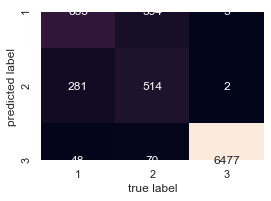

In [15]:
# Ploting confusion matrix with 'seaborn' module
# Use below line only with Jupyter Notebook
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib
mat = confusion_matrix(test_labels, predicted)
plt.figure(figsize=(4, 4))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(test_labels),
            yticklabels=np.unique(test_labels))
plt.xlabel('true label')
plt.ylabel('predicted label')
# Save confusion matrix to outputs in Workbench
# plt.savefig(os.path.join('.', 'outputs', 'confusion_matrix.png'))
plt.show()

## Printing classification report

In [16]:
%matplotlib inline
from sklearn.metrics import classification_report
print(classification_report(test_labels, predicted,
                            target_names=np.unique(test_labels)))

              precision    recall  f1-score   support

           1       0.68      0.72      0.70      1162
           2       0.64      0.53      0.58       978
           3       0.98      1.00      0.99      6482

    accuracy                           0.91      8622
   macro avg       0.77      0.75      0.76      8622
weighted avg       0.90      0.91      0.90      8622

